### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Feb 13 18:23:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.1/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [1]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WMhztrWwnLlCREl5QPS9")
project = rf.workspace("arshad-rv7jf").project("skincancer-kcuu6")
version = project.version(1)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘{HOME}/datasets’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/datasets'
/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to skincancer-1 in yolov11:: 100%|██████████| 2010/2010 [00:00<00:00, 10223.77it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [2]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [3]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=50 imgsz=400 plots=True

[Errno 2] No such file or directory: '{HOME}'
/content
100% 18.4M/18.4M [00:00<00:00, 130MB/s] 
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/skincancer-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=400, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [5]:
!ls /content/runs/detect/train

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1739471504.84c27fb765b3.2497.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1760.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch1761.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch1762.jpg  weights
P_curve.png					    train_batch1.jpg
PR_curve.png					    train_batch2.jpg


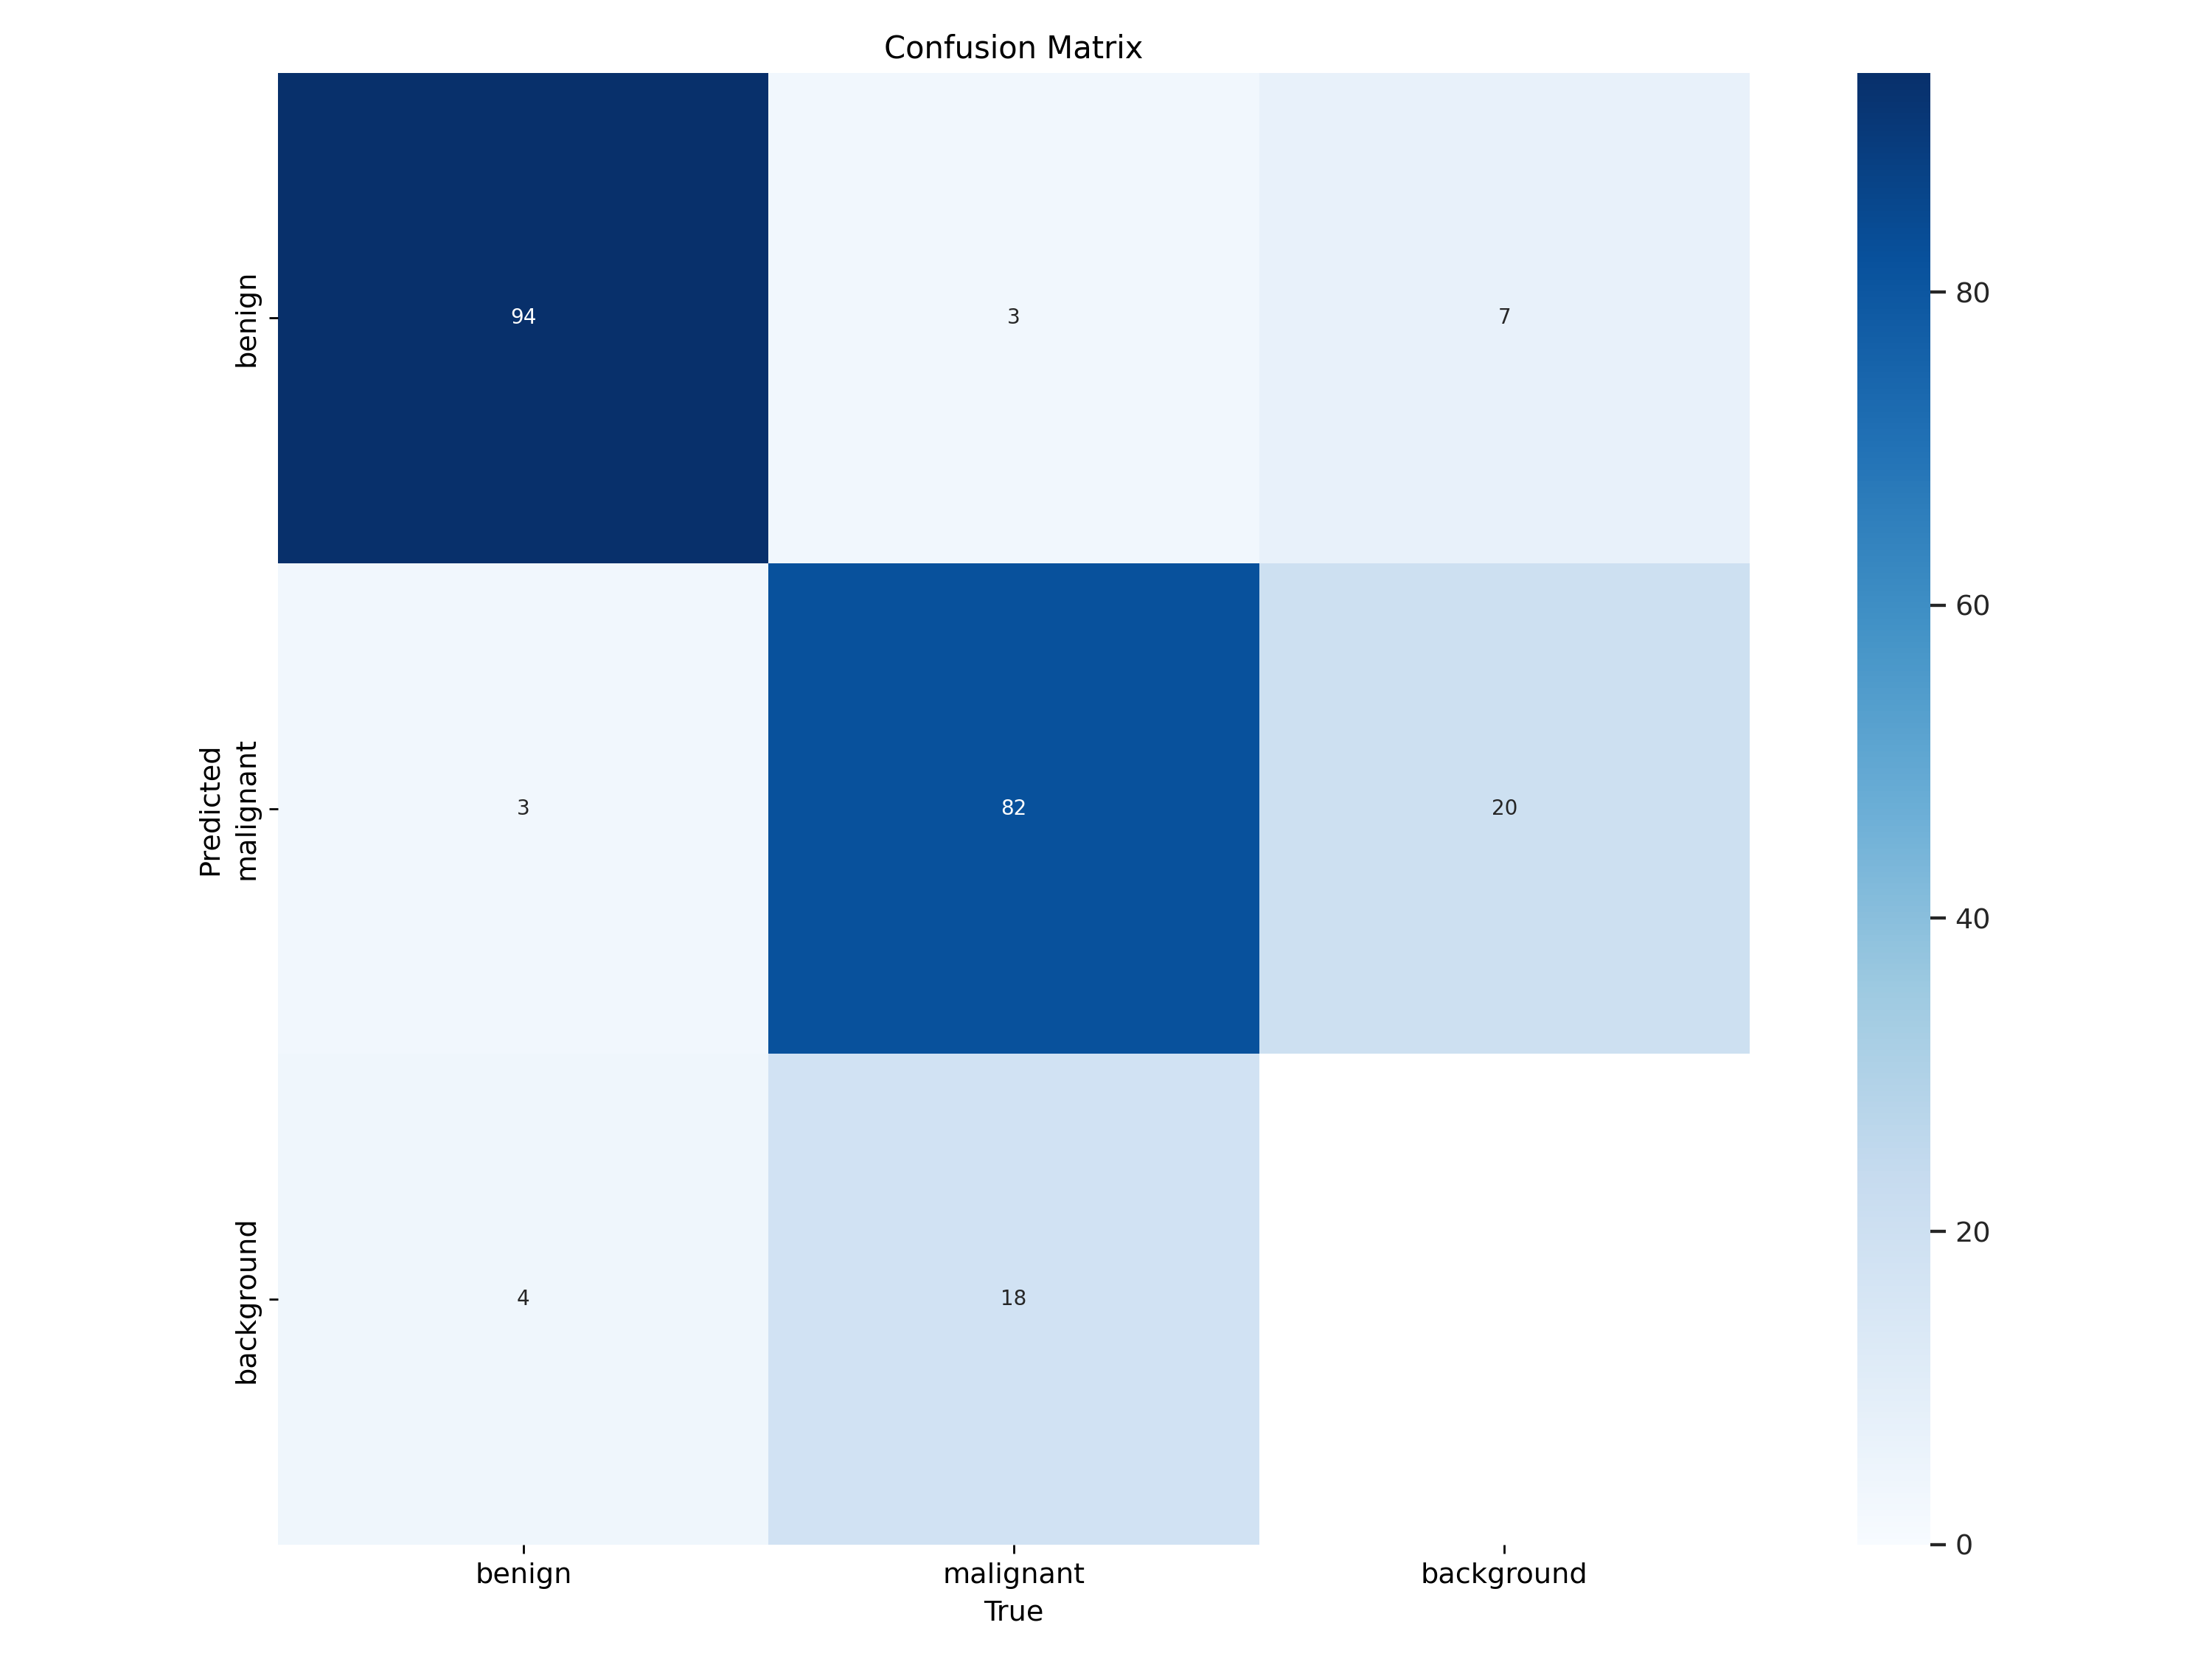

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

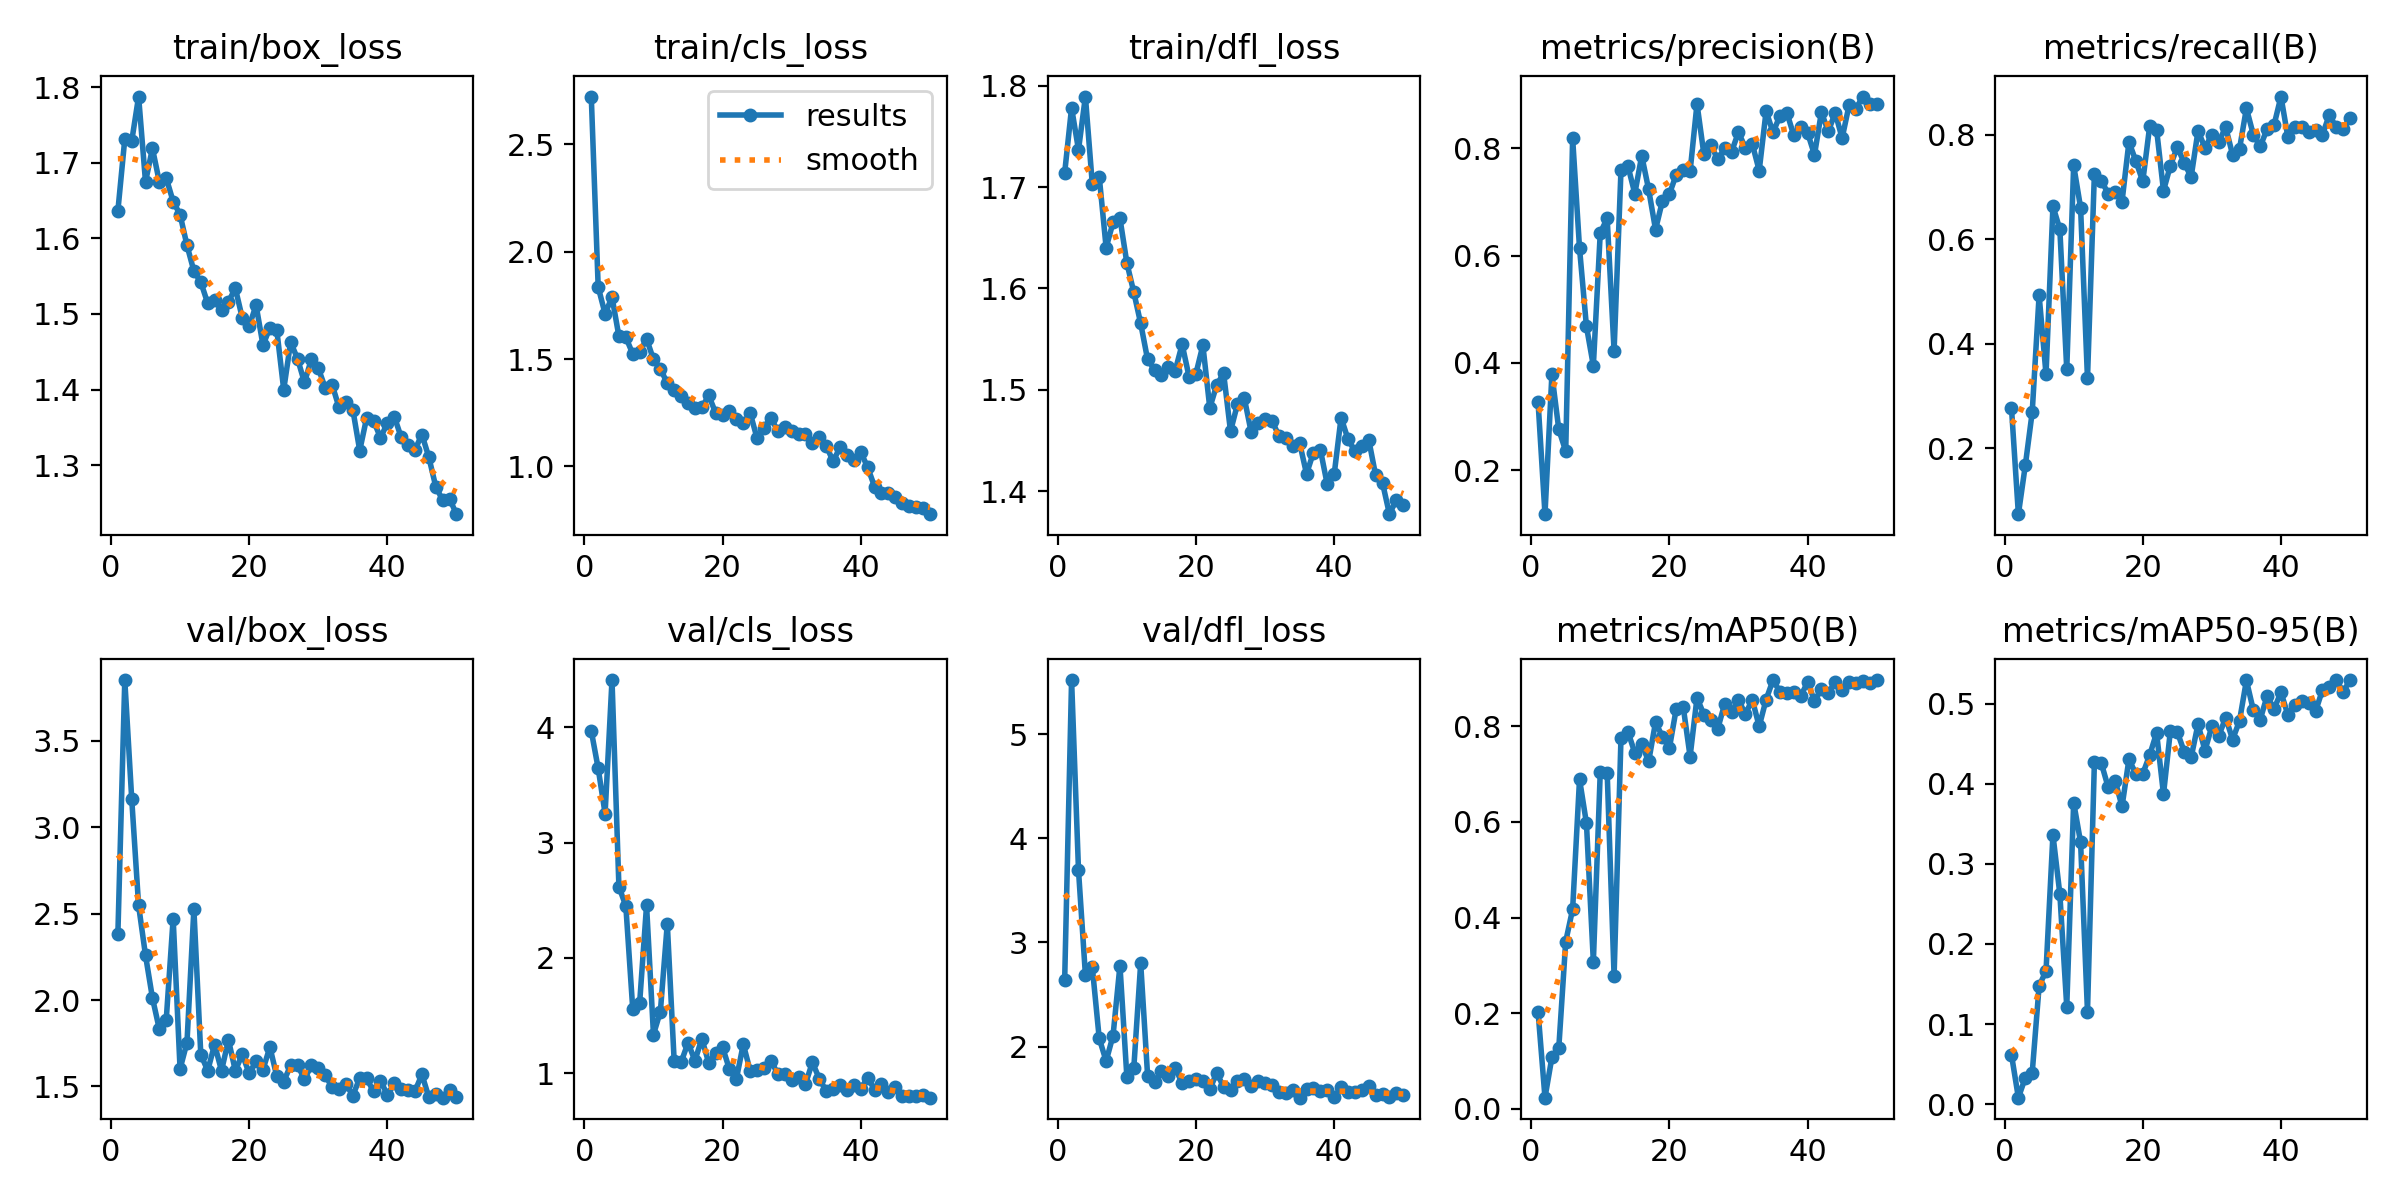

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/results.png', width=600)

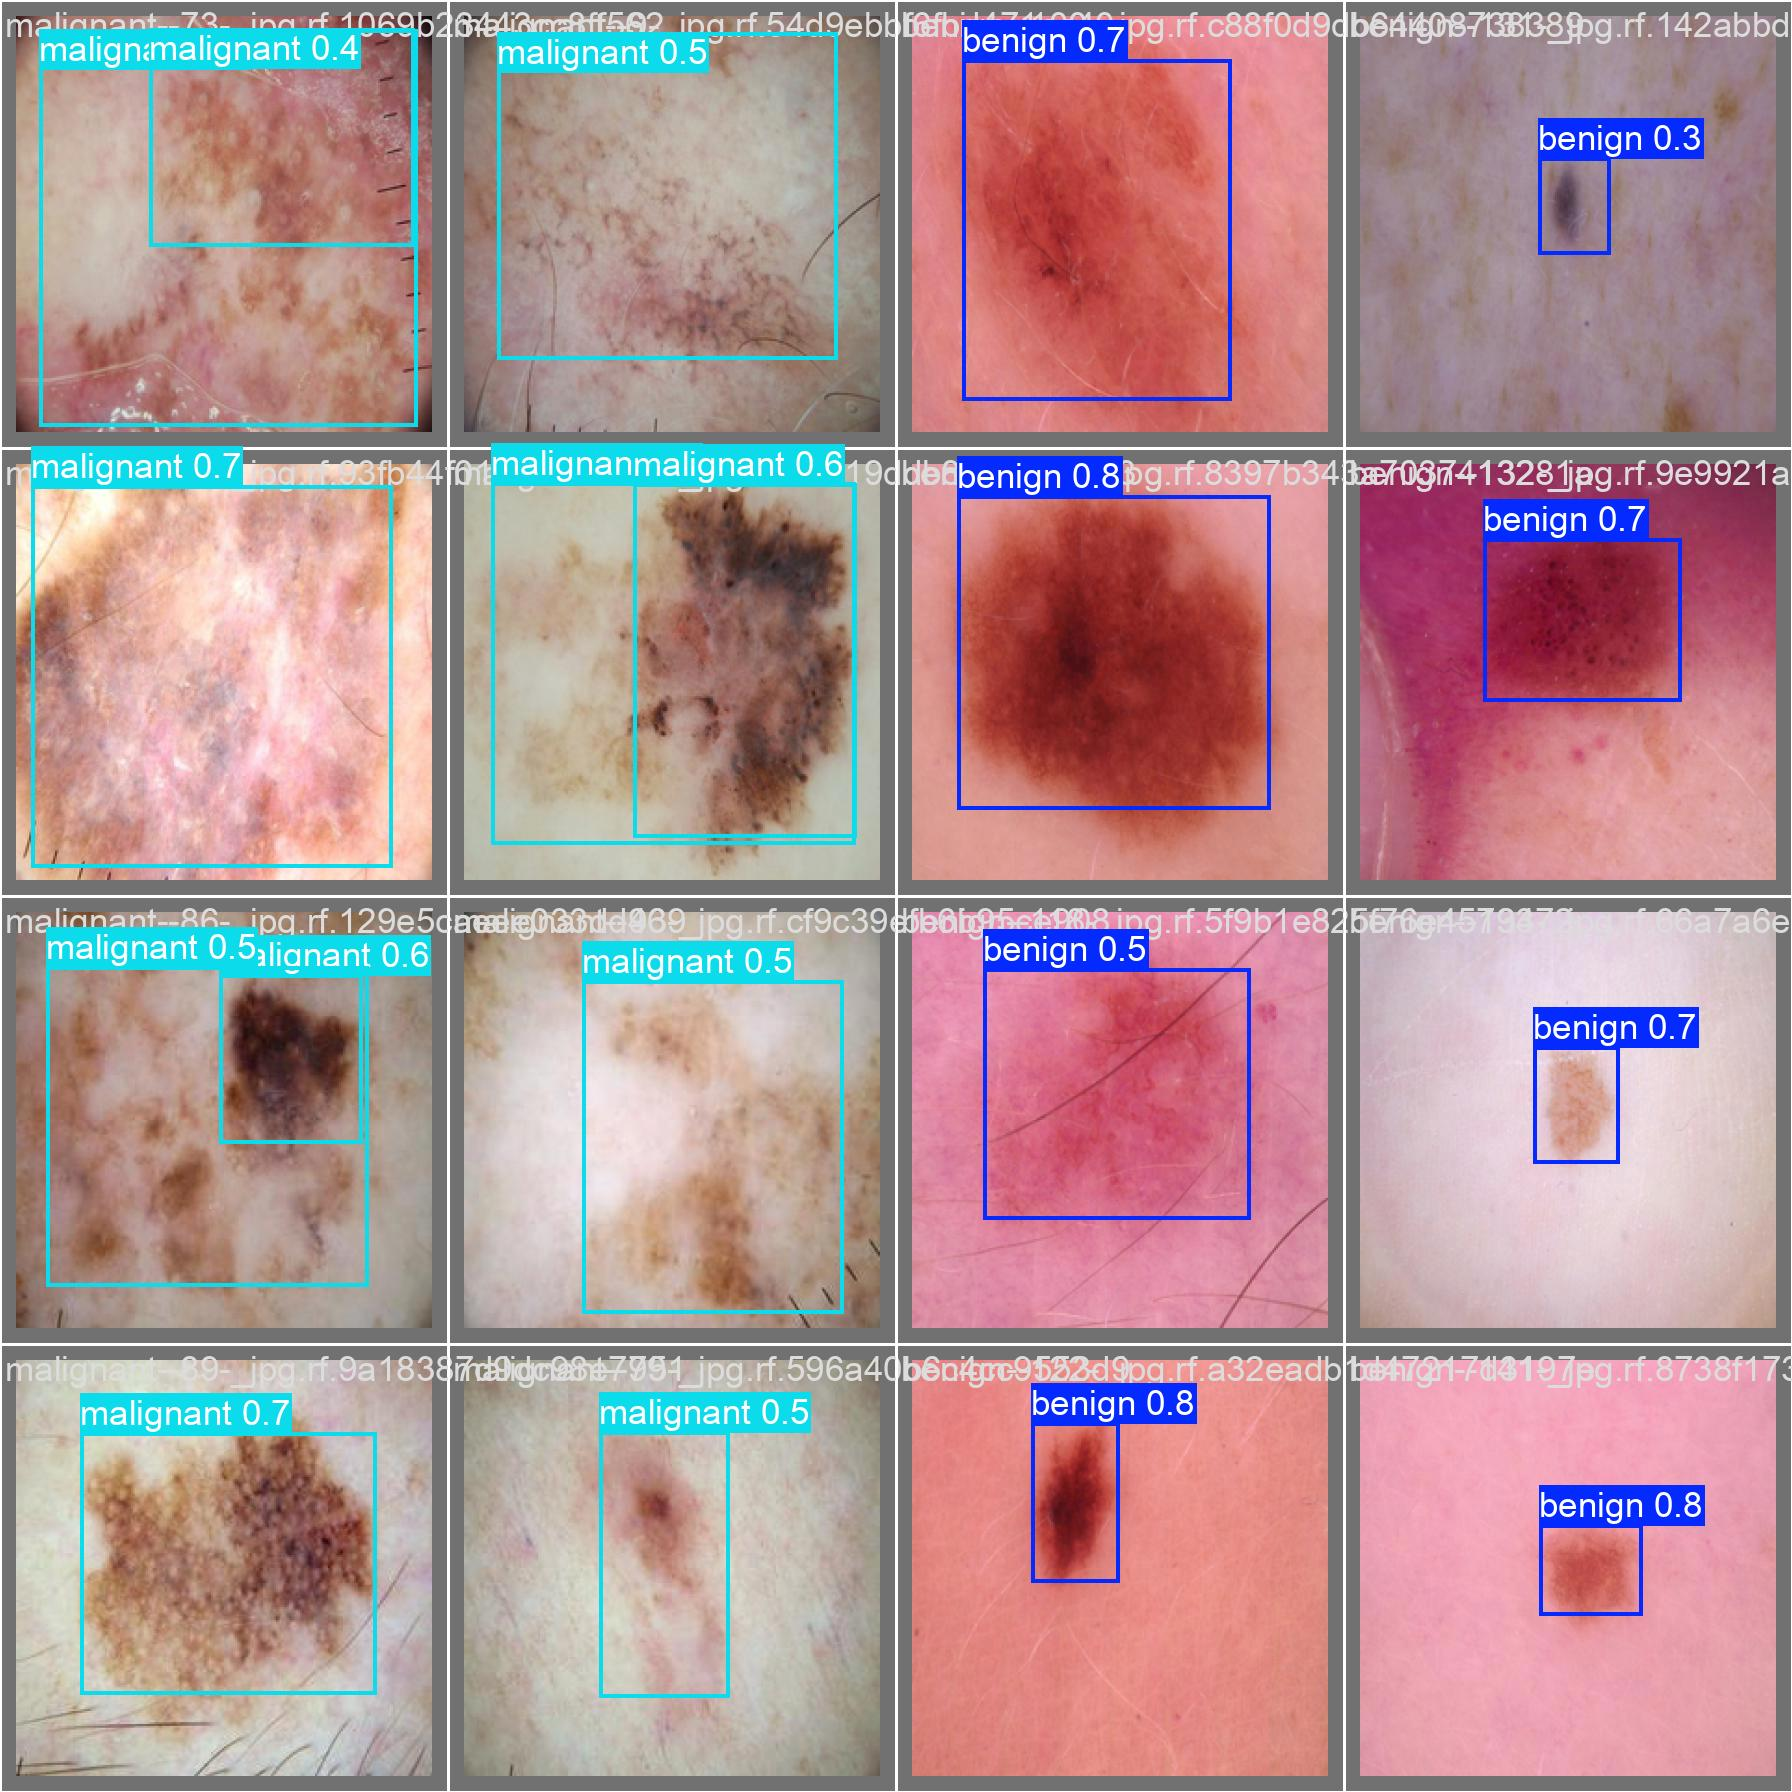

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/skincancer-1/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:02<00:00,  4.90it/s]
                   all        200        204       0.88      0.834      0.896      0.529
                benign        101        101      0.938      0.901      0.955      0.627
             malignant         99        103      0.821      0.767      0.837      0.432
Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [11]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/99 /content/skincancer-1/test/images/benign--101-_jpg.rf.4527a2c26bb5c8c2b447b10c4aa6d59c.jpg: 416x416 1 benign, 12.2ms
image 2/99 /content/skincancer-1/test/images/benign--106-_jpg.rf.226137095f921cd06f5a190d83181f16.jpg: 416x416 1 benign, 10.3ms
image 3/99 /content/skincancer-1/test/images/benign--120-_jpg.rf.e2296c7bfd50d02d775d00754ec8cef3.jpg: 416x416 1 benign, 10.3ms
image 4/99 /content/skincancer-1/test/images/benign--138-_jpg.rf.649d89efe4d0afbcf6d13d6c83457285.jpg: 416x416 1 benign, 10.3ms
image 5/99 /content/skincancer-1/test/images/benign--149-_jpg.rf.234eae34795d38f4387dfd1b18805259.jpg: 416x416 1 benign, 10.3ms
image 6/99 /content/skincancer-1/test/images/benign--156-_jpg.rf.80563d937c911dfe6e50081a92f1c53c.jpg: 416x416 1 benign, 10.3ms
image 7/99 /content/skincancer-1/test/images/benign--158-_jpg.rf.

**NOTE:** Let's take a look at few results.

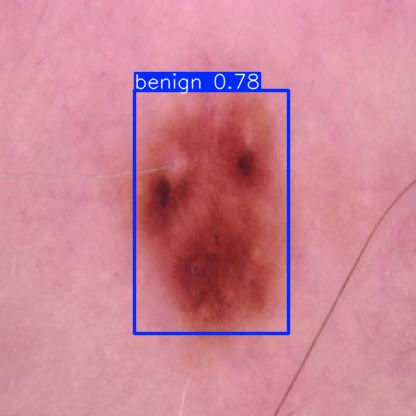

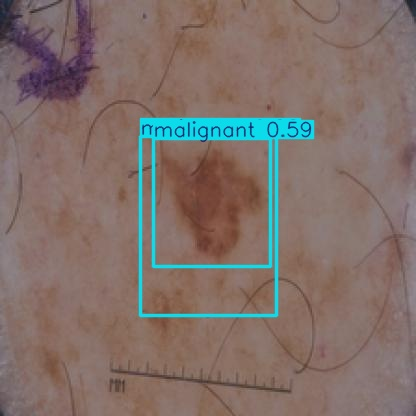

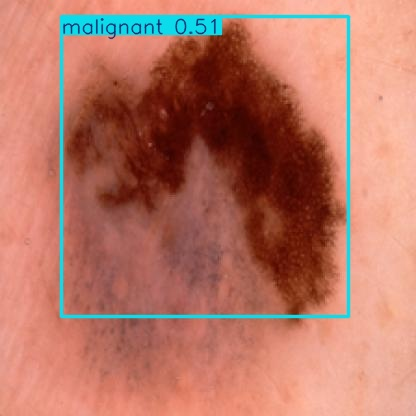

In [12]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")